# Notebook for Daily County AQI

# Data Sampling and Collection

Q: How were the data collected?

A: The dataset on daily county AQI, collected by EPA using outdoor monitors, contains daily AQI defined by PM 2.5 per county across the U.S. This dataset has over 336,701 records from nation-wide stations.

Q: Was there any potential bias introduced in the sampling process?

A:

1. Sampling location distribution is not geographycally uniform. First, outdoor monitors are mostly located in urban areas, leaving rural areas underrepresented in the samples. Second, the number of monitors across states and counties is different. There are more monitors in densely populated areas.

2. Sampling time granularity is a day. The time granularity in each record is daily, which neglects AQI fluctuation in a day. Multiple samples are summarized into one, if samples are taken more than once per day.

3. AQI defining factor. AQI is the data is defined by the pollutant with highest concentration, without taking other air pollutant into consideration.

# Data Cleaning

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

_With data in previous years downloaded, we can choose which year to investigate on. We will take year 2020 as an example. First, load 2020 daily county AQI csv file into a dataframe._

In [44]:
epa_data = {}
year = 2020
daily_county_aqi_str = 'daily_county_aqi' + f'_{year}'
if daily_county_aqi_str not in epa_data:
    epa_data[daily_county_aqi_str] = pd.read_csv(f'daily_aqi_by_county_{year}.csv')

daily_county = epa_data.get(daily_county_aqi_str)
daily_county_datetime = pd.to_datetime(daily_county['Date'])

_Now we narrow down to entries of station reports in US, because we plan to conduct research questions primarily in US region with the use of several datasets._

### Dataset Analysis

Q: What type of data are you exploring?

A: In this dataset, we are exploring categorical and numerical data.

"State Name" is a qualitative nominal variable that represents which state the county is in. 
"county Name" is a quanlitative nominal variable that shows which county the reported AQI belongs to. 
"State Code" is a qualitative nominal variable representing numerical encoding for a state. 
"AQI" is a quantitative descrete variable that indicates air quality defined by a parameter. The lower AQi is, the better air quality. 
"Category" is a qualitative nominal variable that stores air quality class (e.g. good, moderate) corresponding to AQI. 
"Defining Parameter" is a qualitative nominal variable that recoreds which air pollutant is used as air quality measurement. 
"Defining Site" is a qualitative nominal variable that shows which monitor site decides the reported AQI. 
"Number of Sites Reporting" is a quantitative descrete variable that encodes how many monitor sites are used in a county.

Q: What is the granularity of the data?

A: Each row represents the value and class of AQI of a county in U.S. for a given day, defined by a monitor site among several sites. The time range for one csv file is a year.

In [31]:
for key in ["State Name", "county Name", "State Code", "County Code"]:
    print("#" + key + ":")
    print(len(daily_county[key].unique()))
    print()

print("AQI")
print(daily_county["AQI"].describe())
print()

print("Date in datetime format:")
print(daily_county_datetime.describe())
print()

print("Defining Parameter:")
print(daily_county["Defining Parameter"].unique())
print()

print("Defining Site:")
print(len(daily_county["Defining Site"].unique()))
print()

print("Number of Sites Reporting:")
print(daily_county["Number of Sites Reporting"].describe())
print()

#State Name:
54

#county Name:
803

#State Code:
54

#County Code:
168

AQI
count    336701.000000
mean         36.832195
std          22.938766
min           0.000000
25%          26.000000
50%          35.000000
75%          44.000000
max         500.000000
Name: AQI, dtype: float64

Date in datetime format:
count                  336701
unique                    366
top       2020-03-04 00:00:00
freq                     1012
first     2020-01-01 00:00:00
last      2020-12-31 00:00:00
Name: Date, dtype: object

Defining Parameter:
['PM2.5' 'Ozone' 'NO2' 'PM10' 'SO2' 'CO']

Defining Site:
2112

Number of Sites Reporting:
count    336701.000000
mean          2.039195
std           2.432886
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          34.000000
Name: Number of Sites Reporting, dtype: float64



<AxesSubplot:xlabel='AQI', ylabel='Density'>

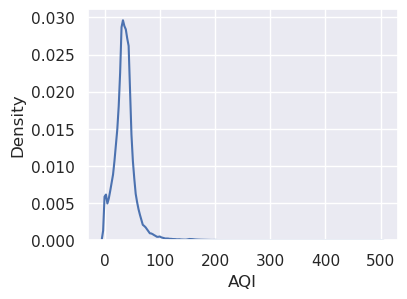

In [60]:
sns.reset_defaults()
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(4,3)})
sns.kdeplot(data=daily_county, x='AQI')

<AxesSubplot:xlabel='Date', ylabel='Density'>

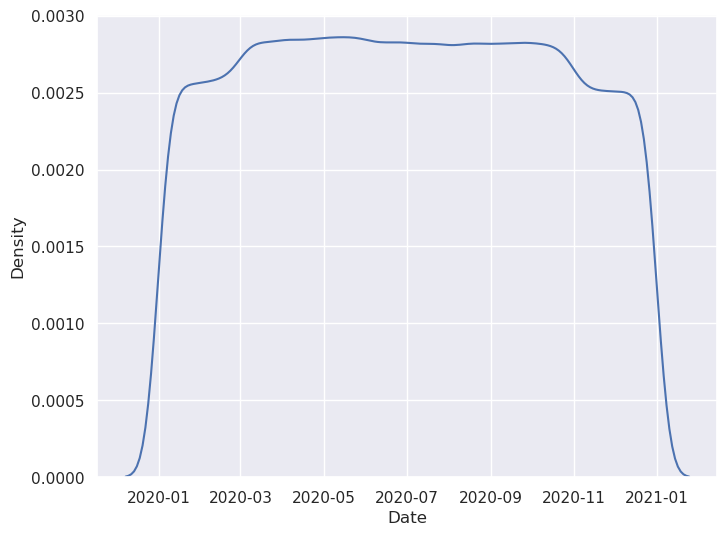

In [62]:
sns.set(rc = {'figure.figsize':(8,6)})
sns.kdeplot(data=daily_county_datetime)

<AxesSubplot:xlabel='Category', ylabel='count'>

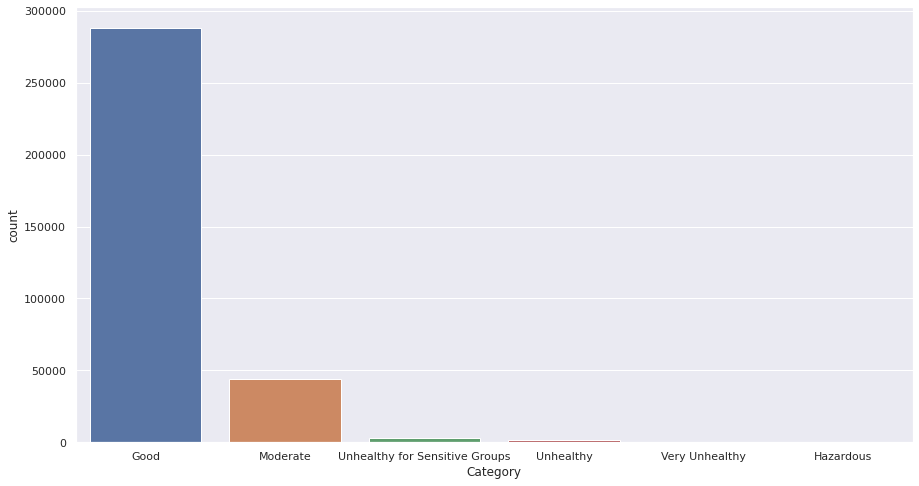

In [25]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="Category", data=daily_county)

<AxesSubplot:xlabel='Defining Parameter', ylabel='count'>

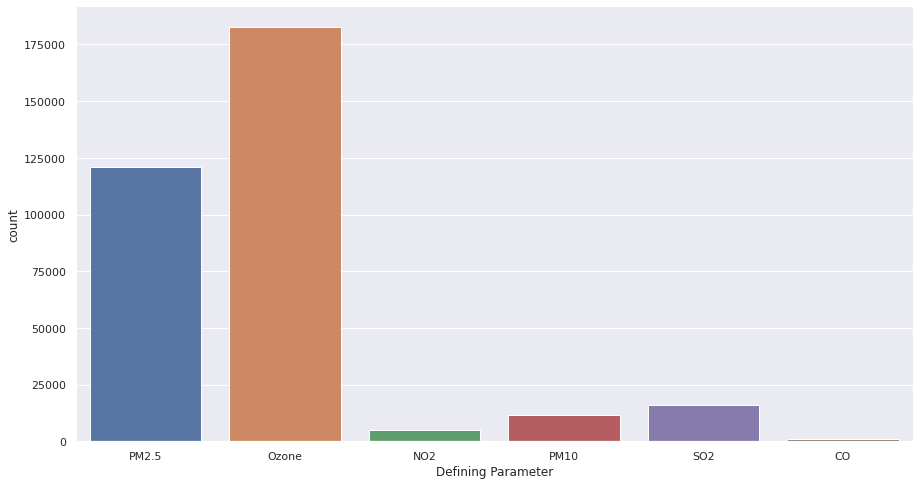

In [46]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="Defining Parameter", data=daily_county)

<AxesSubplot:xlabel='Number of Sites Reporting', ylabel='Density'>

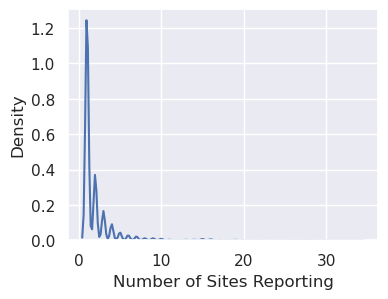

In [81]:
sns.set(rc = {'figure.figsize':(4,3)})
sns.kdeplot(data=daily_county, x='Number of Sites Reporting')

Q: What does the distribution of the data looks like?

Date: Date is uniform. Sampling date per county is every three days or daily if air quality is bad.

AQI: The data follows long tail distribution with positive skew. Mode is around 50 and AQI in most of the day is below 100.

Category: Air quality in most days is good, in some days is moderate, in few days is unhealthy or worse.

Defining Parameter: Ozone and PM2.5 dominates, following SO2, PM10, NO2, and CO.

Number of Sites Reporting: The data follows long tail distribution with positive skew. Mode is 1 and in most counties, there are fewer than 5 sites reporting. In some counties, however, there are more than 30 sites reproting.

In [34]:
print(daily_county.isnull().sum())

State Name                   0
county Name                  0
State Code                   0
County Code                  0
Date                         0
AQI                          0
Category                     0
Defining Parameter           0
Defining Site                0
Number of Sites Reporting    0
Month                        0
day                          0
Day                          0
dtype: int64


In [65]:
print(f'#Days with AQI above 500: {len(daily_county[daily_county["AQI"] > 500])}')

#Days with AQI above 500: 0


Q: Are there missing value or invalid entries in the dataset?

A: The dataset does not contain invalid entries. For missing value, the AQI data for a county is collected every three days is usual or every day when sever air quality condition occurs.

Q: Are there any outliers?

A: There are 46 AQI values that are above 500, which are considered as outlieres. The reason is that AQI is defined in a range from 0 to 500, with 0 meaning excellent air quality and 500 meaning extremely bad air quality. Thus, we treat them as 500 to avoid huge influence on average AQI.

# Exploratory Data Analysis

_First, we do data cleaning. AQI is commonly defined in a range from 0 to 500. AQI above 500 are considered beyond the range and are extremely hazardous. Thus, we limit the maximum AQI to be 500._

In [66]:
daily_county['AQI'] = daily_county['AQI'].apply(lambda x: 500 if x > 500 else x)

_We create auxiliary columns by extracting sampling month and day from year-month-day format._

In [67]:
daily_county['Month'] = pd.DatetimeIndex(daily_county_datetime).month
daily_county['Day'] = pd.DatetimeIndex(daily_county_datetime).day
daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


_Get a mapping between state name and its numerical code._

In [13]:
state_name_code = epa_data.get(daily_county_aqi_str)[['State Name', 'State Code']].groupby('State Name').max()
state_name_code = state_name_code.to_dict('State Name')

## Correlation 1: Is there a seasonal trend for AQI?

_We inspect the data by state since AQI is strongly related to geo areas. Now we focus on data collected from California._

In [14]:
epa_data_CA = {}
state_name = 'California'

for key in epa_data.keys():
    df = epa_data[key]
    if (state_str := 'State Name') in df.columns:
        epa_data_CA[key] = df[df[state_str] == state_name]
    elif (state_str := 'State') in df.columns:
        epa_data_CA[key] = df[df[state_str] == state_name]
    elif (state_str := 'State Code') in df.columns:
        epa_data_CA[key] = df[df[state_str] == state_name_code[state_name]]  # State Name: Califonia, State Code: 6
    else:
        print('error')

daily_county_aqi_CA = epa_data_CA.get(daily_county_aqi_str)

_Draw a line plot to visualize AQI trend for a state in a year._

Text(0, 0.5, 'Aqverage AQI')

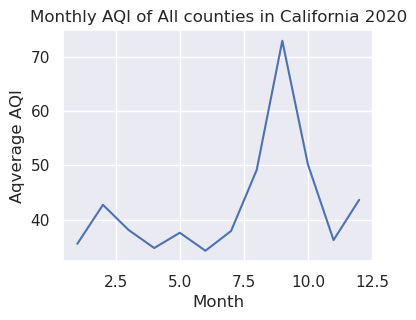

In [82]:
# Average across day within a month.
county_month_aqi = daily_county_aqi_CA[['county Name', 'Month', 'AQI']].groupby(['county Name', 'Month']).mean().reset_index()

# Average across county.
month_aqi = county_month_aqi[['Month', 'AQI']].groupby('Month').mean().reset_index()

# Line plot.
sns.set(rc = {'figure.figsize':(4,3)})
plt.plot(month_aqi['Month'], month_aqi['AQI'])
plt.title('Monthly AQI of All counties in California 2020')
plt.xlabel('Month')
plt.ylabel('Aqverage AQI')

_We can further narrow down to county-wise daily AQI._

Text(0, 0.5, 'Aqverage AQI')

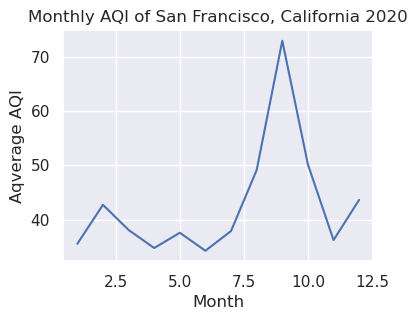

In [83]:
# Filter by county inside a state.
daily_county_aqi_CA = daily_county_aqi_CA[daily_county_aqi_CA['county Name'] == 'San Francisco']

# Average across day within a month.
county_month_aqi = daily_county_aqi_CA[['county Name', 'Month', 'AQI']].groupby(['county Name', 'Month']).mean().reset_index()

# Average across county, placeholder here since county has been filtered.
month_aqi = county_month_aqi[['Month', 'AQI']].groupby('Month').mean().reset_index()

# Line plot.
sns.set(rc = {'figure.figsize':(4,3)})
plt.plot(month_aqi['Month'], month_aqi['AQI'])
plt.title('Monthly AQI of San Francisco, California 2020')
plt.xlabel('Month')
plt.ylabel('Aqverage AQI')

## Correlation 2: Is there a relationship between geographical location and AQI?

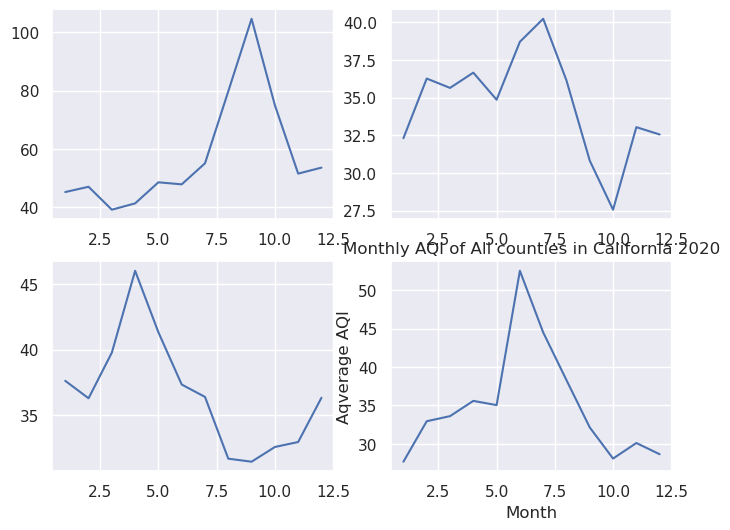

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=2)

state_names = ['California', 'New York', 'Florida', 'Michigan']
i, j = 0, 0

for row in ax:
    for col in row:
        state_name = state_names[i * 2 + j]
        epa_data_state = {}

        for key in epa_data.keys():
            df = epa_data[key]
            if (state_str := 'State Name') in df.columns:
                epa_data_state[key] = df[df[state_str] == state_name]
            elif (state_str := 'State') in df.columns:
                epa_data_state[key] = df[df[state_str] == state_name]
            elif (state_str := 'State Code') in df.columns:
                epa_data_state[key] = df[df[state_str] == state_name_code[state_name]]
            else:
                print('error')

        daily_county_aqi_state = epa_data_state.get(daily_county_aqi_str)

        # Average across day within a month.
        county_month_aqi = daily_county_aqi_state[['county Name', 'Month', 'AQI']].groupby(['county Name', 'Month']).mean().reset_index()

        # Average across county.
        month_aqi = county_month_aqi[['Month', 'AQI']].groupby('Month').mean().reset_index()

        # Line plot.
        col.plot(month_aqi['Month'], month_aqi['AQI'])
        plt.title('Monthly AQI of All counties in California 2020')
        plt.xlabel('Month')
        plt.ylabel('Aqverage AQI')
        
        j += 1
    
    i += 1
    j = 0

plt.show()

Q: Is there any correlation between the variables you are interested in exploring?

1. There is seasonal trend for AQI. Take counties in California as an example, summer has the worst air quality while other three seasons have good air quality. AQI reaches peak in August.

2. There is correlation between geographical location (longitude and latitude) and AQI trend. States in different location have different seasonal AQI trends.

Q: How would you cleanly and accurately visualize the relationship among variables?

Several techniques are used to cleanly and accurately visualize the relationship.

Given that we care about the average temperature and precipitation across the month, we use averaging to allow the data to generalize and be more smooth. Then, to observe clean and clear trend, we properly select graphing method and use proper color, and display size. We also use subplots to compare plots of different granularity on a certain topic.

